# Synthetic data generation

In [1]:
import warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed")

In [2]:
import pandas as pd

In [3]:
# choice: 'basic', 'id'
synthesizer = 'id'

## Load transactions

In [4]:
data = pd.read_csv('../data/transactions.csv')
data.head(10)

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,mean_income
0,0,695247,2378,1993-01-01,1,2.0,700.0,700.0,NaN,NaN,NaN,[ 11271.53754941]
1,1,695250,2378,1993-01-22,1,2.0,7268.0,7968.0,NaN,NaN,NaN,[ 11271.53754941]
2,2,695266,2378,1993-01-23,1,2.0,14440.0,22408.0,NaN,NaN,NaN,[ 11271.53754941]
3,3,695262,2378,1993-01-24,1,2.0,49752.0,72160.0,NaN,NaN,NaN,[ 11271.53754941]
4,4,695265,2378,1993-01-26,1,2.0,21899.0,94059.0,NaN,NaN,NaN,[ 11271.53754941]
5,5,695560,2378,1993-01-31,0,3.0,34700.0,59453.7,NaN,NaN,NaN,[ 11271.53754941]
6,6,3608592,2378,1993-01-31,1,NaN,94.7,94153.7,2,NaN,NaN,[ 11271.53754941]
7,7,695272,2378,1993-02-05,1,2.0,30192.0,89645.7,NaN,NaN,NaN,[ 11271.53754941]
8,8,695340,2378,1993-02-07,0,0.0,9612.0,80033.7,4,EF,1222903.0,[ 11271.53754941]
9,9,695270,2378,1993-02-11,1,2.0,31038.0,111071.7,NaN,NaN,NaN,[ 11271.53754941]


## Clean dataset

* Leave target columns only (so far: type, operation, amount)
* Filter NaN values
* Convert columns to appropriate type

In [5]:
if synthesizer == 'id':
    data = data[['account_id', 'type', 'operation', 'amount']]
else:
    data = data[['type', 'operation', 'amount']]
data = data.dropna()
data = data[data['type'] != 'VYBER']
if synthesizer == 'id':
    data['account_id'] = data['account_id'].astype(dtype='int32')
    id_normalization = {x: n for n, x in enumerate(data['account_id'].unique())}
    data['account_id'] = data['account_id'].map(arg=id_normalization)
data['type'] = data['type'].astype(dtype='int')
data['type'] = data['type'].astype(dtype='category')
data['operation'] = data['operation'].astype(dtype='int')
data['operation'] = data['operation'].astype(dtype='category')
data['amount'] = data['amount'].astype(dtype='float32')
data.head(10)

,account_id,type,operation,amount
0,0,1,2,700.0
1,0,1,2,7268.0
2,0,1,2,14440.0
3,0,1,2,49752.0
4,0,1,2,21899.0
5,0,0,3,34700.0
7,0,1,2,30192.0
8,0,0,0,9612.0
9,0,1,2,31038.0
10,0,0,3,25200.0


## Train model and synthesized data

In [6]:
if synthesizer == 'id':
    from synthesized.core import IdSynthesizer
    synthesizer = IdSynthesizer
elif synthesizer == 'basic':
    from synthesized.core import BasicSynthesizer
    synthesizer = BasicSynthesizer

In [7]:
with synthesizer(dtypes=data.dtypes) as synthesizer:
    synthesizer.learn(data=data, verbose=5000)
    synthesized = synthesizer.synthesize(n=10000)

5000: 1.27e+08
10000: 1.44e+08
15000: 1.64e+08
20000: 1.73e+08
25000: 4.37e+07
30000: 2.93e+07
35000: 2.48e+06
40000: 3.16e+06
45000: 1.15e+07
50000: 5.26e+06


## Display synthesized data

In [8]:
synthesized.head(10)

,type,operation,amount,account_id
0,1,3,9579.436523,1845
1,0,3,3504.253418,4175
2,1,1,13645.117188,3132
3,0,3,5452.193848,3664
4,0,3,3976.727783,2480
5,0,3,9232.264648,2714
6,1,3,8521.383789,3058
7,1,2,12993.032227,3219
8,1,2,12234.659180,2618
9,0,0,5929.611816,1371


# Visualization of original and synthetic data

In [9]:
data['type'].hist(bins=2, range=[0, 1])

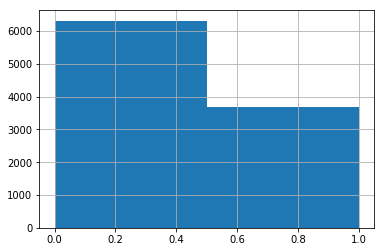

In [10]:
synthesized['type'].hist(bins=2, range=[0, 1])

In [ ]:
data['operation'].hist(bins=4, range=[0, 3])

In [ ]:
synthesized['operation'].hist(bins=4, range=[0, 3])

In [ ]:
data['amount'].hist(bins=10, range=[0.0, 10000.0])

In [ ]:
synthesized['amount'].hist(bins=10, range=[0.0, 10000.0])

# Tests to confirm the utility of synthetic data 

In [ ]:
from synthesized.testing.testing_environment import Testing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [ ]:
testing = Testing(data, synthesized)

In [ ]:
testing.estimate_utility(
    continuous_columns=['amount'],  categorical_columns=['type', 'operation'],
    classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor()
)

In [ ]:
testing.compare_marginal_distributions(target_column='operation', filter_column='amount')

In [ ]:
testing.compare_marginal_distributions(target_column='type', filter_column='amount', bins=10)